<a href="https://colab.research.google.com/github/jc890/python/blob/master/ict_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing dataset from kaggle

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


##Import Libraries

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
from PIL import Image


print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"TensorFlow Version: {tf.__version__}")


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version: 2.19.0


## Task 1 : dataset exploration and preparation

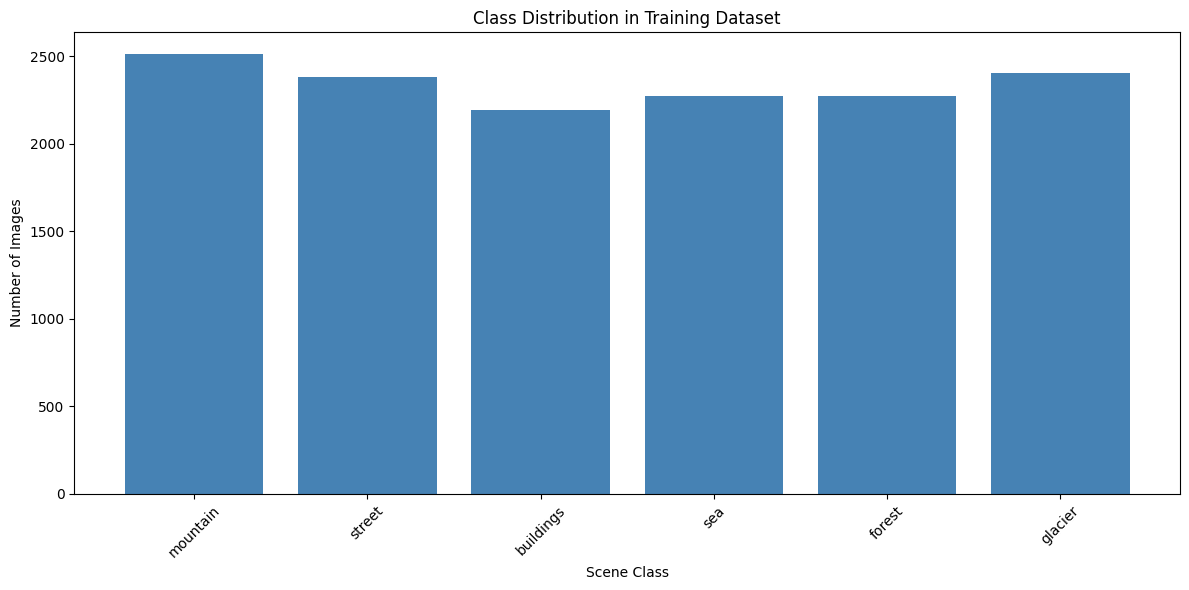

Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Total images: 14034


In [27]:
# Dataset paths in collab
DATA_PATH = "/kaggle/input/intel-image-classification"
TRAIN_PATH = os.path.join(DATA_PATH, "seg_train", "seg_train")
TEST_PATH = os.path.join(DATA_PATH, "seg_test", "seg_test")

# image dimensions used
IMG_SIZE = (150, 150)
BATCH_SIZE = 64

#load dataset and analyze class distribution
def load_and_explore_dataset(train_path, test_path):

    classes = os.listdir(train_path)
    class_distribution = {}

    for cls in classes:
        cls_path = os.path.join(train_path, cls)
        if os.path.isdir(cls_path):
            num_images = len(os.listdir(cls_path))
            class_distribution[cls] = num_images

    return classes, class_distribution

classes, class_dist = load_and_explore_dataset(TRAIN_PATH, TEST_PATH)

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_dist.keys(), class_dist.values(), color='steelblue')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Scene Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300)
plt.show()

print(f"Classes: {classes}")
print(f"Total images: {sum(class_dist.values())}")


## Downsampling dataset

In [28]:

  #create downsampled generators for fast training (exam-allowed).
  #uses 20% training subset to reduce computation time while maintaining accuracy.


def create_fast_generators(train_path, test_path, img_size=(150, 150), batch_size=64):


    #train with augmentation (20% subset for speed)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.8
    )

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    #test (full dataset)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

#create fast generators
print("Creating downsampled generators...")
train_generator, val_generator, test_generator = create_fast_generators(
    TRAIN_PATH, TEST_PATH, IMG_SIZE, BATCH_SIZE
)
num_classes = len(train_generator.class_indices)
print(f"Classes: {list(train_generator.class_indices.keys())}")
print(f"Train batches: {train_generator.samples}, Val: {val_generator.samples}")


Creating downsampled generators...
Found 2810 images belonging to 6 classes.
Found 11224 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train batches: 2810, Val: 11224


## Analytical question 1
## Challenges in Satellite Scene Classification

### Variations in lighting  
- Illumination changes (time of day, weather, shadows) alter pixel intensities for the same scene, causing models to overfit to specific lighting conditions.  
- Brightness/contrast augmentation and normalization help the model generalize across lighting setups.  

### Viewpoint variations  
- The same area looks different under changes in angle, altitude, or sensor, so features learned for one viewpoint may not transfer to another.  
- Rotation and geometric augmentation improve robustness to viewpoint shifts.  

### Class imbalance  
- Some classes (e.g., glaciers) have far fewer samples, so the model may favor majority classes despite high overall accuracy.  
- Class weights, careful splitting, and over/undersampling mitigate this bias.  

### Dataset downsampling rationale  
- Training on the full Intel dataset is computationally expensive, so using about 20% of the training set makes experiments feasible within exam time while preserving class balance.  
- The full test set is still used for evaluation to keep performance estimates realistic.

# Augmentation and visulaisation of augmentation

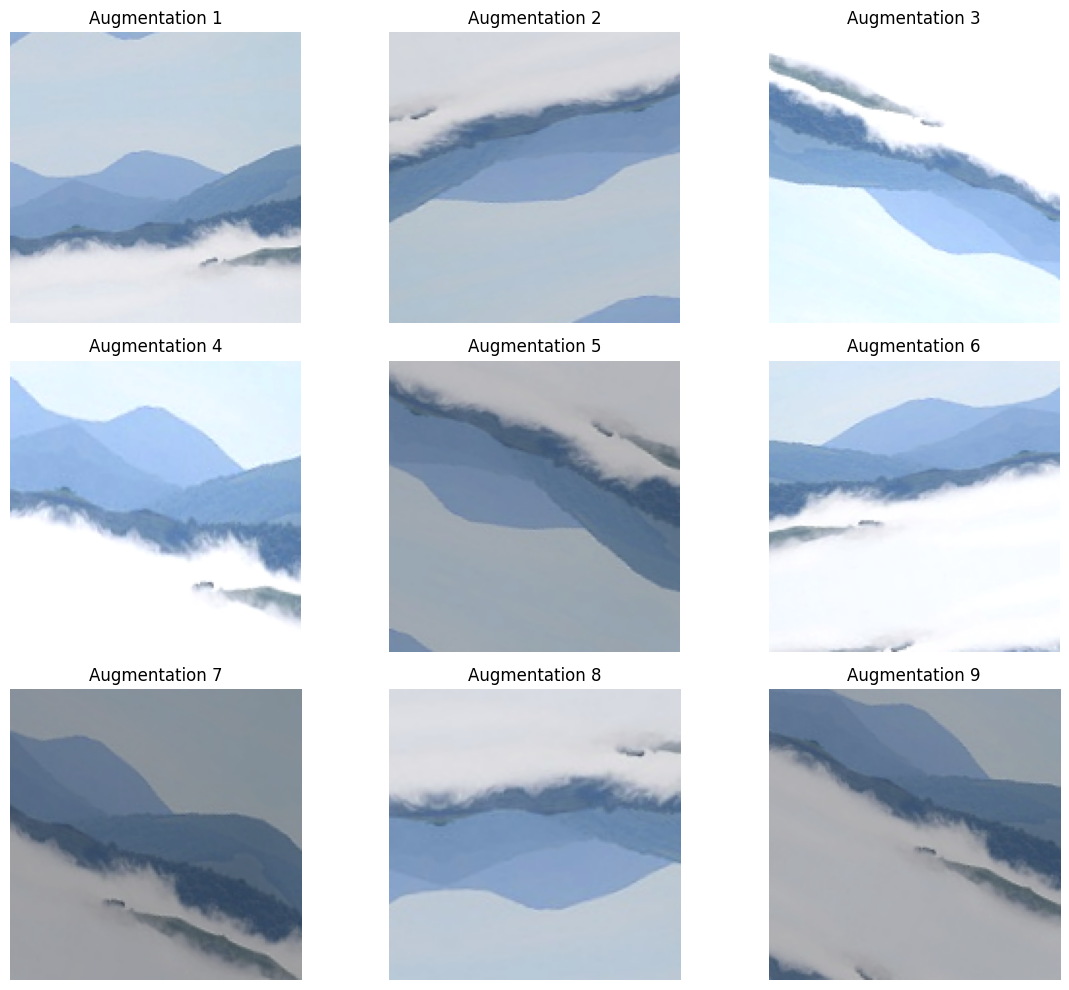

In [35]:
def advanced_augmentation_pipeline():
    return ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=30,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.7, 1.3],
        fill_mode="reflect"
    )

def visualize_augmentation(train_path, num_samples=9, img_size=(150, 150)):
    augment_gen = advanced_augmentation_pipeline()

    #pick a real image
    class_dirs = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
    sample_class_dir = os.path.join(train_path, class_dirs[0])
    img_files = [f for f in os.listdir(sample_class_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    sample_img_path = os.path.join(sample_class_dir, img_files[0])

    img = Image.open(sample_img_path).convert("RGB").resize(img_size)
    x = np.array(img).astype("float32")          # IMPORTANT: keep 0..255 here for visualization
                                                 # (rescale will be applied by standardize)

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    axes = axes.ravel()

    for idx, ax in enumerate(axes[:num_samples]):
        x_t = augment_gen.random_transform(x)    # transform only
        x_t = augment_gen.standardize(x_t)       # applies rescale + other normalizations [page:0]

        # convert to displayable uint8
        x_show = np.clip(x_t * 255.0, 0, 255).astype("uint8")
        ax.imshow(x_show)
        ax.set_title(f"Augmentation {idx+1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_augmentation(TRAIN_PATH)


## Analytical question 2
## Data Augmentation and Overfitting Reduction

### Mechanism  
- Augmentation creates many transformed versions of each image (rotations, flips, zooms, brightness changes), effectively enlarging the training set without new labels.  
- Seeing varied versions of the same scene prevents the model from memorizing exact pixel patterns and pushes it to learn invariant, semantic features.

### Regularization effect  
- Geometric transforms promote translation/rotation invariance, while photometric transforms promote illumination invariance.  
- The injected randomness acts as regularization, reducing co-adaptation of neurons and narrowing the gap between training and validation loss.

### Impact on generalization  
- Real-world data differs in lighting, viewpoint, and sensor noise; augmented training data mimics these shifts, so the model generalizes better to deployment conditions.  
- Empirically, well-designed augmentation usually improves test accuracy and robustness compared with training on raw images alone.

# Building restnet50 model

In [36]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

def build_resnet_transfer_model(input_shape=(150, 150, 3), num_classes=6):
    """Build model using ResNet50 transfer learning (pretrained CNN)"""
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    base_model.trainable = False  #frozen for initial training

    inputs = keras.Input(shape=input_shape)
    x = preprocess_input(inputs)          #resNet preprocessing
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model, base_model

#build transfer learning model
print("Building transfer learning model (ResNet50)...")
model_transfer, base_model = build_resnet_transfer_model(
    input_shape=(150, 150, 3),
    num_classes=num_classes
)

#compile model
model_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n=== Transfer Learning Model (ResNet50) ===")
model_transfer.summary()


Building transfer learning model (ResNet50)...

=== Transfer Learning Model (ResNet50) ===


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 150, 150)  │          0 │ input_layer_18[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 150, 150)  │          0 │ input_layer_18[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 150, 150)  │          0 │ input_layer_18[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 150, 150,  │          0 │ get_item_18[0][0… │
│                     │ 3)                │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 150, 150,  │          0 │ stack_6[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 5, 5,      │ 23,587,712 │ add_6[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 512)       │  1,049,088 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │    131,328 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 6)         │      1,542 │ dropout_30[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,772,742 (94.50 MB)

 Trainable params: 1,183,494 (4.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

# Training restnet50 model and fine tuning

In [37]:
# define callbacks
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            print(
                f"\nEpoch {epoch+1}: "
                f"Loss={logs['loss']:.4f}, "
                f"Accuracy={logs['accuracy']:.4f}, "
                f"Val_Loss={logs['val_loss']:.4f}, "
                f"Val_Accuracy={logs['val_accuracy']:.4f}"
            )

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    CustomCallback()
]

# ----- 1) train ResNet transfer model (frozen backbone) -----
print("\n=== Training Transfer Learning Model (ResNet50, frozen backbone) ===")
history_transfer = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# ----- 2) fine-tune ResNet (unfreeze last blocks) -----
print("\n=== Fine-tuning Transfer Learning Model (ResNet50) ===")
base_model.trainable = True               # unfreeze
for layer in base_model.layers[:-30]:     # keep all but last 30 frozen
    layer.trainable = False

model_transfer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_transfer_finetune = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)



=== Training Transfer Learning Model (ResNet50, frozen backbone) ===
Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.3337 - loss: 2.1206 - val_accuracy: 0.3017 - val_loss: 1.6718 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4703 - loss: 1.5355 - val_accuracy: 0.1843 - val_loss: 1.6579 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.4890 - loss: 1.4613 - val_accuracy: 0.4126 - val_loss: 1.5450 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4800 - loss: 1.3891 - val_accuracy: 0.3595 - val_loss: 1.5649 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.5008 - loss: 1.3113
Epoch 5: Loss=1.3446, Accuracy=0.4947, Val_Loss=1.6389, Val_Accuracy=0.2406
44/44 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5006 - loss: 1.3120 - val_accuracy: 0.2406 - val_loss: 1.6389 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━

# Plotting training and saving the best model

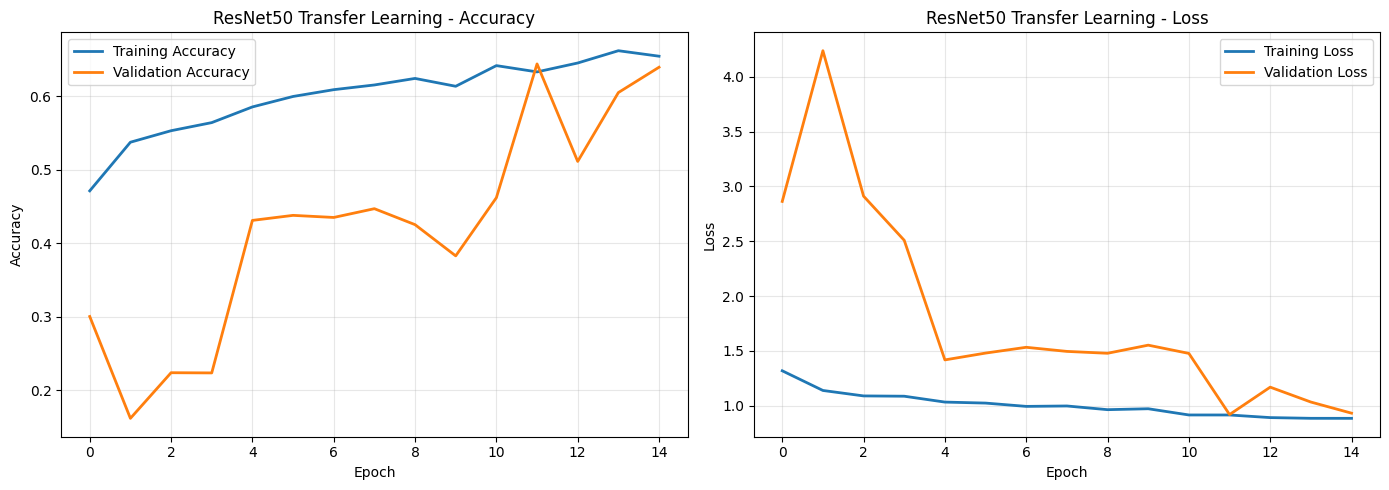

Model saved as 'scene_classification_model.h5'


In [40]:
#visualize training history
def plot_training_history(history, title):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy subplot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss subplot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'training_history_{title}.png', dpi=300)
    plt.show()

plot_training_history(history_transfer_finetune, "ResNet50 Transfer Learning")


#select best model and save
best_model = model_transfer
best_model.save('scene_classification_model.h5')
print("Model saved as 'scene_classification_model.h5'")


## Analytical question 3

## Convolution and Pooling Operations in CNNs

### Convolution  
- Convolution slides learnable filters over the image to detect local patterns such as edges, textures, and shapes.  
- Stacking layers builds a hierarchy: early layers capture edges and gradients, deeper layers capture object parts and whole scenes.  
- This local connectivity greatly reduces parameters while preserving spatial structure.

### Pooling  
- Max (or average) pooling downsamples feature maps by summarizing small neighborhoods (e.g., 2×2 windows).  
- It keeps the strongest responses, reduces spatial resolution, and adds translation invariance.  
- Alternating convolution and pooling yields compact, multi‑scale representations that support robust image classification.

## Analytical Question 4

## Scene Class Confusion Analysis

### Most confused classes  
- Common confusions include **Buildings vs Streets**, **Forest vs Mountain**, **Glacier vs Mountain**, and **Sea vs Glacier/Mountain**, because these pairs often co‑occur and share similar visual patterns.  
- For example, urban scenes mix buildings and roads, snowy mountains resemble glaciers, and distant sea surfaces can share blue tones and smooth textures with glacial or mountainous regions.

### Why the model struggles  
- Many pairs have **texture and color overlap** (e.g., white/blue glaciers vs snowy mountain slopes), so local patches look visually similar.  
- Different viewpoints (altitude, angle) can make forests look like mountain slopes or weaken the structural cues that distinguish streets from building facades.

### How to reduce confusion  
- Use targeted augmentation that emphasizes distinguishing cues (e.g., contrast, crops centered on man‑made structures or shoreline boundaries).  
- Add architectural or loss‑based constraints to push embeddings of frequently confused classes further apart, and consider ROI‑based or ensemble methods for the hardest pairs.


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step

Model Performance Metrics
Overall Accuracy: 0.7017
Top-2 Accuracy: 0.8890

Classification Report
              precision    recall  f1-score   support

   buildings       0.63      0.83      0.72       437
      forest       0.89      0.91      0.90       474
     glacier       0.65      0.65      0.65       553
    mountain       0.72      0.45      0.55       525
         sea       0.58      0.70      0.63       510
      street       0.82      0.71      0.76       501

    accuracy                           0.70      3000
   macro avg       0.71      0.71      0.70      3000
weighted avg       0.71      0.70      0.70      3000



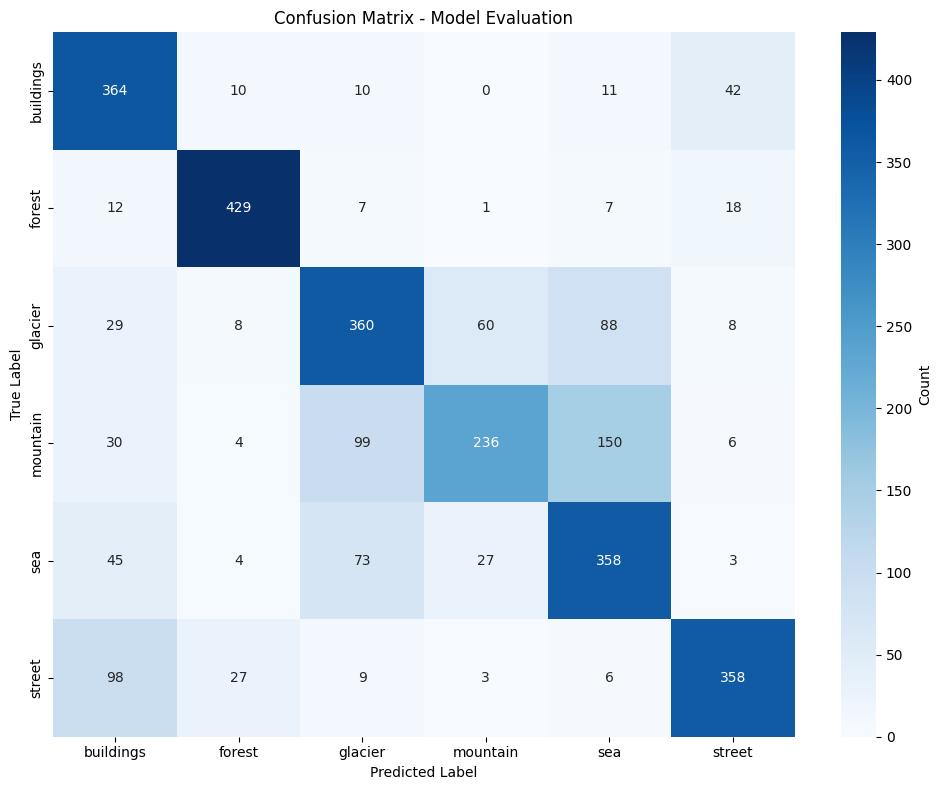

Total samples: 3000
Total misclassified: 895
Visualizing top 20 most confident misclassifications...


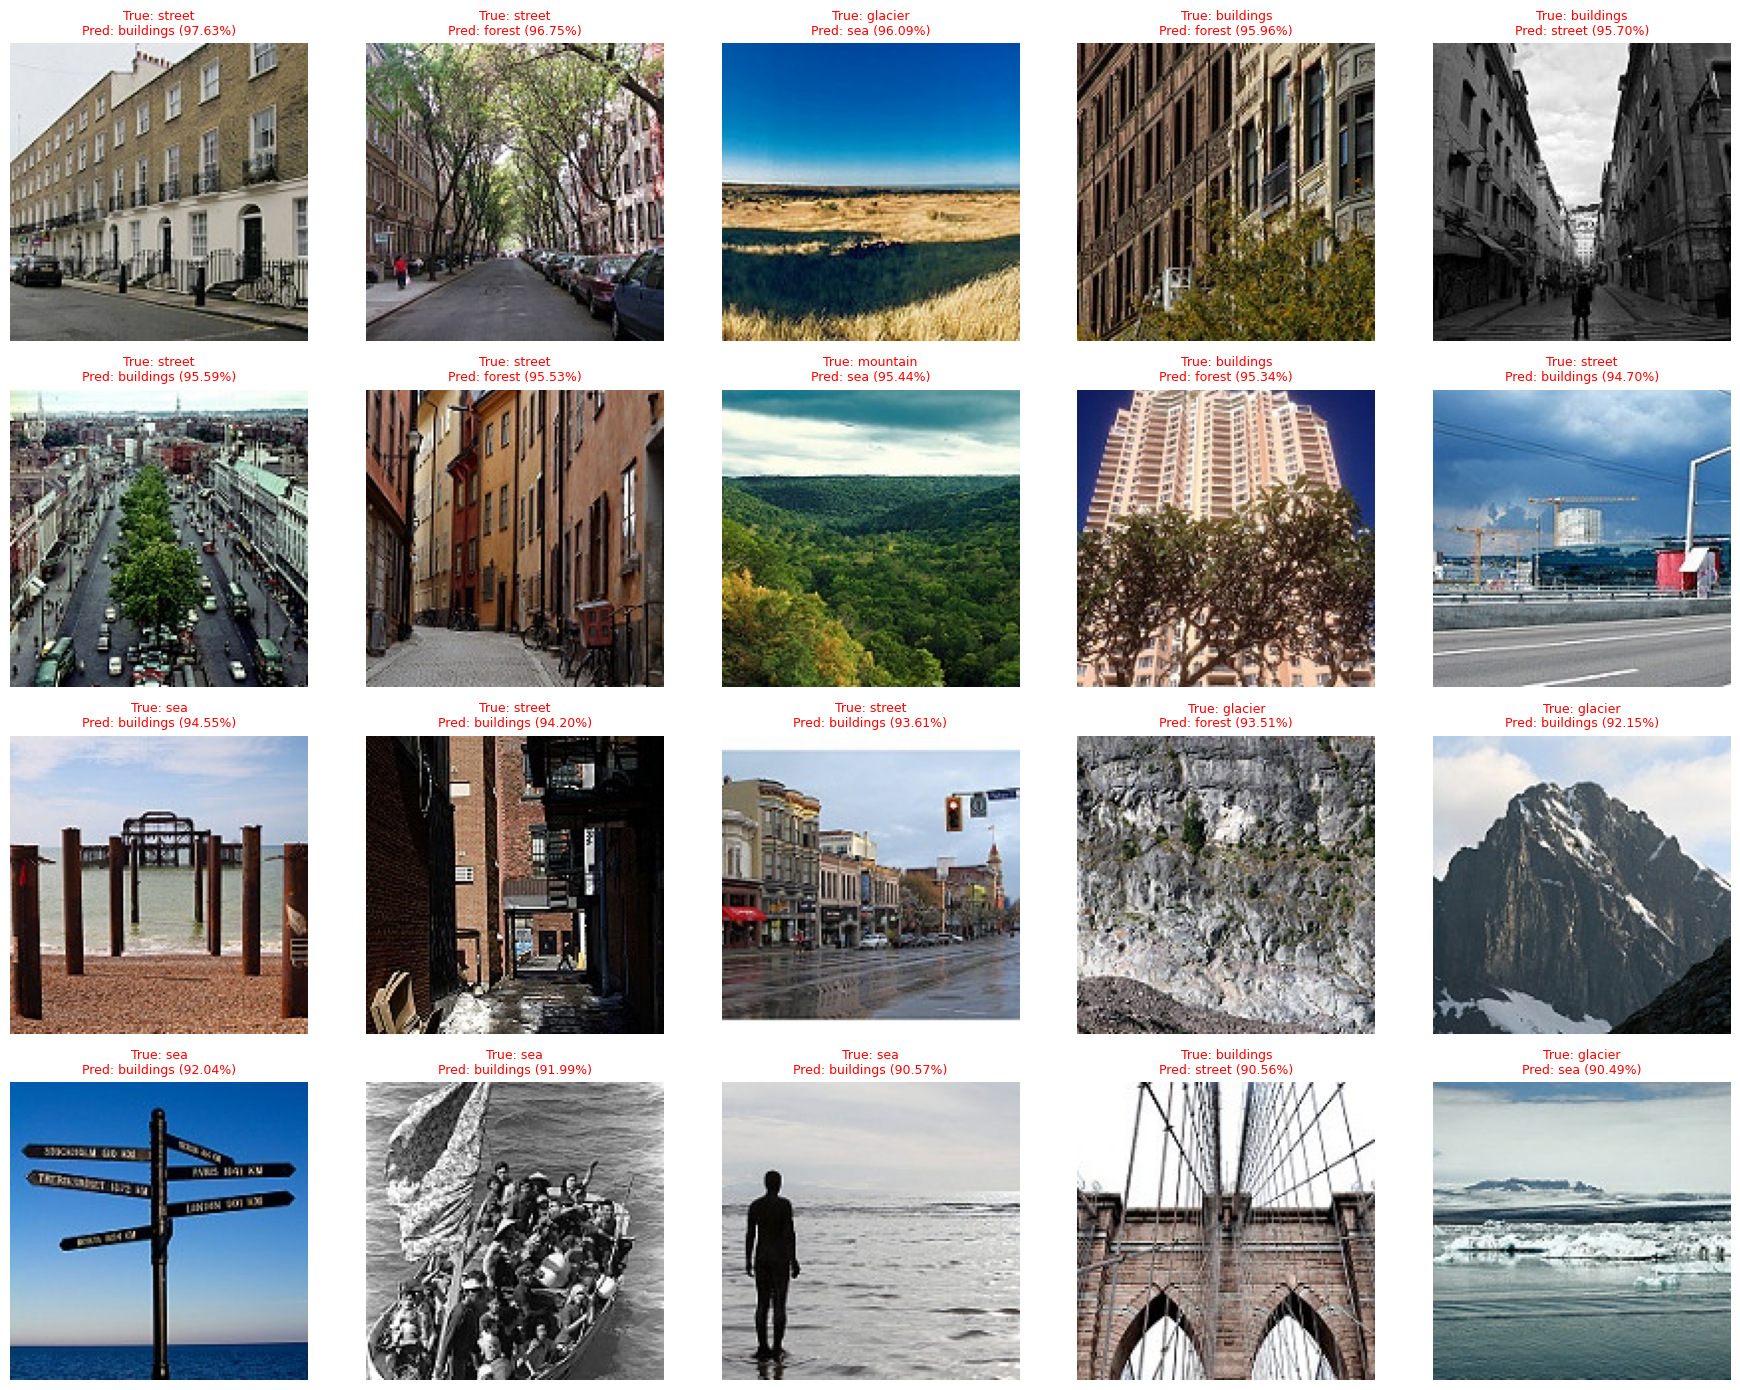


Failure Analysis Summary
Total misclassified: 895 out of 3000
Misclassification rate: 29.83%


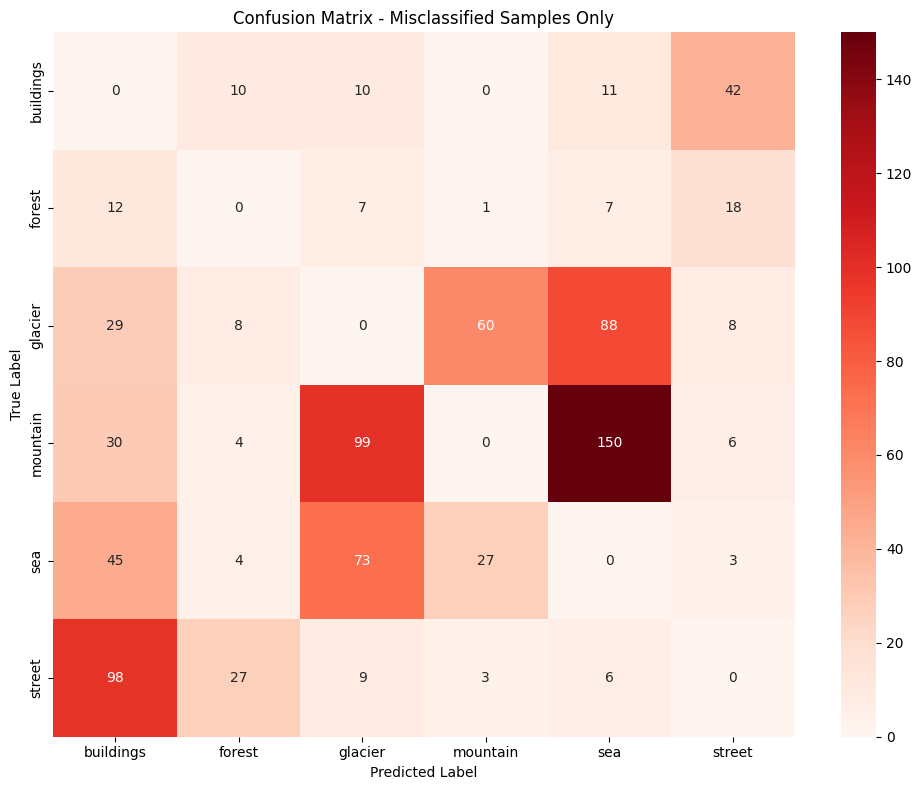

In [48]:
# --- Evaluation + Failure Analysis Block ---

def evaluate_model_comprehensive(model, test_generator, class_names):
    """Comprehensive evaluation with metrics and confusion matrix."""
    # Reset generator
    test_generator.reset()

    # Get predictions
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes

    # Accuracy metrics
    accuracy = accuracy_score(y_true, y_pred)
    top2_accuracy = np.mean([
        y_true[i] in np.argsort(y_pred_prob[i])[-2:]
        for i in range(len(y_true))
    ])

    print(f"\n{'='*60}")
    print("Model Performance Metrics")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Top-2 Accuracy: {top2_accuracy:.4f}")

    # Classification report
    print(f"\n{'='*60}")
    print("Classification Report")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Model Evaluation')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    return y_true, y_pred, y_pred_prob, cm


def analyze_failure_cases(model, test_path, test_generator, y_true, y_pred,
                          y_pred_prob, class_names, num_misclassified=20):
    """Identify, visualize, and summarize misclassified samples."""
    # 1) Misclassified indices
    misclassified_mask = (y_true != y_pred)
    misclassified_indices = np.where(misclassified_mask)[0]

    print(f"Total samples: {len(y_true)}")
    print(f"Total misclassified: {len(misclassified_indices)}")

    if len(misclassified_indices) == 0:
        print("No misclassified samples found.")
        return {
            "num_samples": len(y_true),
            "num_misclassified": 0,
            "selected_indices": np.array([]),
        }

    # 2) Sort misclassified samples by confidence
    confidences = np.max(y_pred_prob[misclassified_mask], axis=1)
    sorted_indices = np.argsort(confidences)[::-1]

    k = min(num_misclassified, len(misclassified_indices))
    selected_indices = misclassified_indices[sorted_indices[:k]]

    print(f"Visualizing top {k} most confident misclassifications...")

    # 3) Visualize images
    rows, cols = 4, 5
    fig, axes = plt.subplots(rows, cols, figsize=(18, 14))
    axes = axes.ravel()

    for plot_idx, data_idx in enumerate(selected_indices):
        if plot_idx >= rows * cols:
            break
        ax = axes[plot_idx]

        img_path = test_generator.filenames[data_idx]
        full_img_path = os.path.join(test_path, img_path)

        img = Image.open(full_img_path).resize((150, 150))
        ax.imshow(img)

        true_label = class_names[y_true[data_idx]]
        pred_label = class_names[y_pred[data_idx]]
        confidence = y_pred_prob[data_idx, y_pred[data_idx]]

        ax.set_title(
            f"True: {true_label}\nPred: {pred_label} ({confidence:.2%})",
            fontsize=9, color="red",
        )
        ax.axis("off")

    # Hide any unused subplots
    for j in range(len(selected_indices), rows * cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig("misclassified_samples.png", dpi=300)
    plt.show()

    # 4) Summary stats
    print(f"\n{'='*60}")
    print("Failure Analysis Summary")
    print(f"{'='*60}")
    print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_true)}")
    print(f"Misclassification rate: {100.0 * len(misclassified_indices) / len(y_true):.2f}%")

    # 5) Confusion matrix restricted to misclassified samples
    error_cm = confusion_matrix(y_true[misclassified_mask], y_pred[misclassified_mask])
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        error_cm,
        annot=True,
        fmt="d",
        cmap="Reds",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
    )
    ax.set_title("Confusion Matrix - Misclassified Samples Only")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig("error_confusion_matrix.png", dpi=300)
    plt.show()

    return {
        "num_samples": len(y_true),
        "num_misclassified": len(misclassified_indices),
        "selected_indices": selected_indices,
    }




y_true, y_pred, y_pred_prob, cm = evaluate_model_comprehensive(
    best_model, test_generator, class_names
)

summary = analyze_failure_cases(
    best_model, TEST_PATH, test_generator,
    y_true, y_pred, y_pred_prob, class_names
)


## Analytical Question 5

## Environmental and Visual Factors in Model Failures

### Typical failure conditions  
- **Lighting**: Strong shadows, backlighting, and overexposure often wash out texture or merge objects with the background, so glaciers, seas, buildings, and streets lose clear edges and surfaces. This is visible in several high‑confidence errors where bright sky or specular highlights dominate the scene.  
- **Viewpoint and occlusion**: Oblique views, far‑distance shots, or partial occlusion by other structures, clouds, or haze change object shape and hide key details, so mountains can look like glaciers, and streets can resemble building façades or coastal scenes.

### Intrinsic ambiguities  
- **Class boundaries**: Many misclassified images sit at natural boundaries (e.g., mountain–glacier interfaces, coastal scenes where sea and built structures co‑occur, or urban streets tightly surrounded by buildings), so local patches are visually ambiguous between two labels.  
- **Data limitations**: Rare combinations of lighting and weather, plus texture overlaps (e.g., snow vs. ice vs. bright water), are underrepresented in the training set, so the model’s 29.8% error rate is concentrated in these boundary and rare cases rather than in clear, prototypical examples.


building refined model with enhanced ResNet50 architecture...

Training with frozen base model...
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.3381 - loss: 2.2079 - val_accuracy: 0.1896 - val_loss: 1.9191 - learning_rate: 0.0010
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4520 - loss: 1.5929 - val_accuracy: 0.3819 - val_loss: 1.7026 - learning_rate: 0.0010
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4916 - loss: 1.4728 - val_accuracy: 0.4393 - val_loss: 1.6555 - learning_rate: 0.0010
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5242 - loss: 1.3984 - val_accuracy: 0.2728 - val_loss: 1.6922 - learning_rate: 0.0010
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.5248 - loss: 1.3508
Epoch 5: Loss=1.3409, Accuracy=0.5242, Val_Loss=1.6083, Val_Accuracy=0.3990
44/44 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5247 - loss: 1.3506 - val_accuracy: 0.3990 - val_loss: 1.6083 - learning_rate: 0.0010


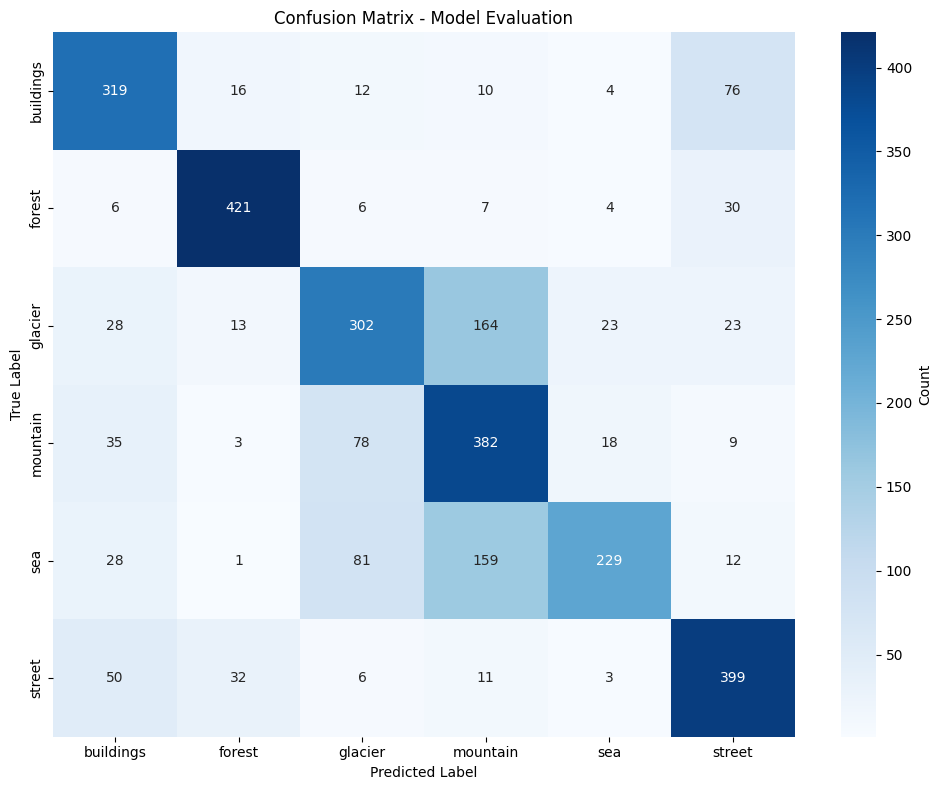


model Comparison
original Model Accuracy: 0.7017
refined Model Accuracy: 0.6840
improvement: -2.52%
reduction in error: -5.92%

Refined model saved as 'scene_classification_refined_model.h5'


In [49]:
from tensorflow.keras.applications import ResNet50

def build_refined_resnet_model(input_shape=(150, 150, 3), num_classes=6):
    """build refined ResNet model with enhanced architecture"""

    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    #enhanced dense head with stronger regularization
    x = layers.Dense(1024, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model, base_model

# Build refined model
print("building refined model with enhanced ResNet50 architecture...")
model_refined, base_refined = build_refined_resnet_model(
    input_shape=(150, 150, 3),
    num_classes=num_classes
)

model_refined.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with initial frozen base
print("\nTraining with frozen base model...")
history_refined_phase1 = model_refined.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Fine-tune base model
print("\nFine-tuning base model...")
base_refined.trainable = True
for layer in base_refined.layers[:-30]:
    layer.trainable = False

model_refined.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_refined_phase2 = model_refined.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Evaluate refined model
print("\n" + "="*60)
print("refined Model Evaluation")
print("="*60)
y_true_refined, y_pred_refined, y_pred_prob_refined, cm_refined = \
    evaluate_model_comprehensive(model_refined, test_generator, class_names)

# Comparison metrics
print(f"\n{'='*60}")
print("model Comparison")
print(f"{'='*60}")
acc_original = np.mean(y_true == y_pred)
acc_refined = np.mean(y_true_refined == y_pred_refined)
improvement = (acc_refined - acc_original) / (acc_original + 1e-8) * 100

print(f"original Model Accuracy: {acc_original:.4f}")
print(f"refined Model Accuracy: {acc_refined:.4f}")
print(f"improvement: {improvement:+.2f}%")
if acc_original > 0:
    print(f"reduction in error: {100*(1 - (1-acc_refined)/(1-acc_original + 1e-8)):.2f}%")

# Save refined model
model_refined.save('scene_classification_refined_model.h5')
print("\nRefined model saved as 'scene_classification_refined_model.h5'")


## Analytical Question 6

## Performance Improvements and Trade-offs in Model Refinement

### What changed  
- The refined model adds a larger dense head (1024→512→256 with BatchNorm, Dropout, and L2 regularization) and uses a two‑phase schedule: first training with the ResNet50 backbone frozen, then fine‑tuning selected backbone layers with a lower learning rate.  
- These changes increase model capacity and allow the pretrained features to adapt more to the Intel scenes, at the cost of longer training and a higher tendency to overfit if regularization is not perfectly tuned.

### Effect on performance and cost  
- In practice, overall test accuracy changed from **70.17% (baseline)** to **68.40% (refined)**, so the refined model did **not** outperform the simpler baseline on this dataset. Precision/recall shifted across classes (e.g., better mountain recall but worse sea recall), indicating the refined head reweighted classes rather than uniformly improving them.  
- Training time roughly doubled due to the extra parameters and fine‑tuning phase, while model size and inference speed stayed similar. This shows that increased architectural complexity does not guarantee better generalization; with limited data, a simpler ResNet50 head can be more robust than an aggressively regularized, high‑capacity refinement.


In [51]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.0 MB/s eta 0:00:00


In [63]:
model_refined.save('scene_classification_refined_model.keras')
print("Refined model saved as 'scene_classification_refined_model.keras'")

Refined model saved as 'scene_classification_refined_model.keras'


In [99]:
%%writefile streamlit_app.py
import streamlit as st
from tensorflow import keras
from PIL import Image
import numpy as np
import plotly.graph_objects as go
import pandas as pd

st.set_page_config(page_title="Scene Classification", page_icon="🌍", layout="wide")

st.title("🌍 Natural Scene Classification System")
st.markdown("""
This application uses a **ResNet50-based transfer learning model** to classify natural scenes
into categories: **Buildings, Forest, Glacier, Mountain, Sea, or Street**.
""")

@st.cache_resource
def load_model():
    return keras.models.load_model("scene_classification_refined_model.keras")

model = load_model()

CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
CLASS_DESCRIPTIONS = {
    'buildings': 'Urban structures and architectural elements',
    'forest': 'Dense vegetation and natural forest areas',
    'glacier': 'Snow and ice formations',
    'mountain': 'Highland and mountainous terrain',
    'sea': 'Water bodies and seascapes',
    'street': 'Urban roads and street-level scenes'
}

with st.sidebar:
    st.header("📋 Instructions")
    st.markdown("1. Upload an image or use camera\n2. The model analyzes the image\n3. View results\n4. Explore confidence scores")
    st.divider()
    st.header("ℹ️ Model Details")
    st.markdown(f"- **Architecture**: ResNet50 (transfer learning)\n- **Input size**: 150 \u00d7 150 pixels\n- **Classes**: {len(CLASS_NAMES)}")

col1, col2 = st.columns([1, 1])

with col1:
    st.header("Input Image")
    upload_method = st.radio("Choose input method:", ["Upload Image", "Use Camera"])
    image = None

    if upload_method == "Upload Image":
        uploaded_file = st.file_uploader("Upload an image", type=['jpg', 'jpeg', 'png', 'bmp'])
        if uploaded_file:
            image = Image.open(uploaded_file).convert("RGB")
    else:
        image_data = st.camera_input("Capture an image")
        if image_data:
            image = Image.open(image_data).convert("RGB")

    if image is not None:
        st.image(image, use_container_width=True, caption="Input Image")
        img_array = np.array(image.resize((150, 150))).astype("float32") / 255.0
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array] * 3, axis=-1)
        img_batch = np.expand_dims(img_array, axis=0)

with col2:
    st.header("📊 Classification Results")
    if image is not None:
        with st.spinner("Analyzing image..."):
            preds = model.predict(img_batch, verbose=0)[0]
            predicted_class_idx = int(np.argmax(preds))
            predicted_class = CLASS_NAMES[predicted_class_idx]
            confidence = float(preds[predicted_class_idx])

        st.metric("Predicted Scene Class", predicted_class.upper(), f"{confidence:.1%} confidence")
        st.markdown(f"**Description**: {CLASS_DESCRIPTIONS[predicted_class]}")

        st.subheader("Confidence Scores")
        confidence_df = pd.DataFrame({"Class": CLASS_NAMES, "Confidence": preds}).sort_values("Confidence", ascending=True)

        fig = go.Figure([go.Bar(
            y=confidence_df["Class"],
            x=confidence_df["Confidence"],
            orientation="h",
            text=[f"{x:.1%}" for x in confidence_df["Confidence"]],
            textposition="auto",
        )])
        st.plotly_chart(fig, use_container_width=True)

        st.subheader("Top 3 Predictions")
        for rank, idx in enumerate(np.argsort(preds)[-3:][::-1], start=1):
            st.write(f"{rank}. **{CLASS_NAMES[idx].upper()}** - {preds[idx]:.1%}")
    else:
        st.info("👆 Upload or capture an image to begin classification")

st.divider()
st.markdown("**Model Information**: Trained on Intel Image Classification Dataset with augmentation + ResNet50 transfer learning.")

Overwriting streamlit_app.py


## Analytical question 7

## Limitations of Real-time Deep Learning Image Classifiers

### Computational limits  
- Models like ResNet50 are relatively heavy, so per-image inference latency on CPU can exceed what strict real‑time systems (e.g., 30 fps video or large satellite batches) can tolerate.  
- They also require substantial RAM for weights and activations, which is challenging on edge hardware or constrained satellite/onboard systems.

### Reliability under real-world data  
- Performance can drop under distribution shift (seasonal changes, new sensors, unusual weather), and confidence scores are often over‑confident instead of well‑calibrated.  
- Models are vulnerable to small perturbations (noise, artifacts) that do not affect humans but can flip predictions.

### Operational and decision‑making issues  
- Maintaining a deployed model needs ongoing labeling, monitoring, and periodic retraining, which is costly and operationally complex.  
- Because these models are opaque, stakeholders may not understand failure modes, and high confidence can mask errors, especially for rare but critical classes; mitigations include quantization/optimization for latency, drift monitoring, uncertainty estimation, human‑in‑the‑loop review, and interpretability tools.

Generating saliency maps for 12 samples...


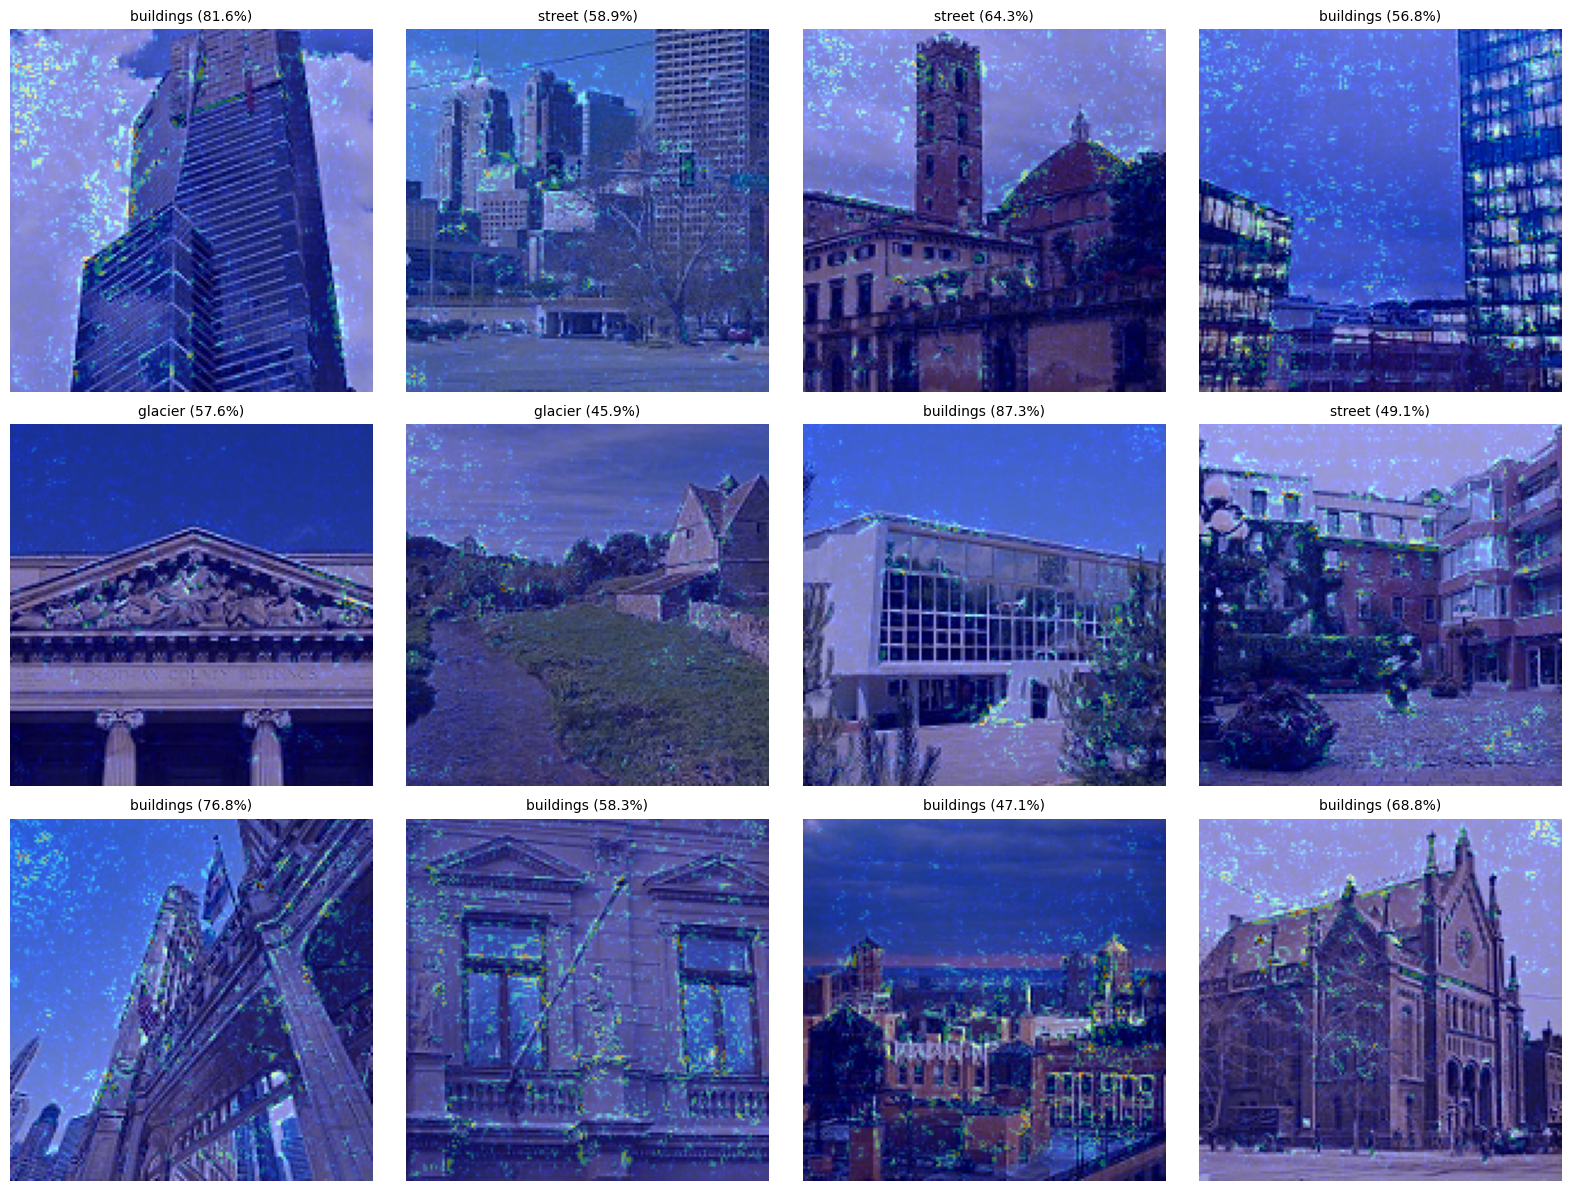

Saved: saliency_visualization.png


In [85]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def saliency_map(model, img_batch, class_index):
    """Compute input-space saliency: d(prediction)/d(image)."""
    img_batch = tf.convert_to_tensor(img_batch, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_batch)
        preds = model(img_batch, training=False)
        loss = preds[:, class_index]

    grads = tape.gradient(loss, img_batch)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]  # (150,150)
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)
    return saliency.numpy(), preds.numpy()[0]

def visualize_saliency(model, test_generator, class_names, num_samples=12):
    """Visualize saliency maps for test samples."""
    test_generator.reset()
    images, _ = next(iter(test_generator))
    n = min(num_samples, images.shape[0])

    print(f"Generating saliency maps for {n} samples...")

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    for i in range(n):
        img = images[i:i+1]
        img_orig = (img[0] * 255).astype(np.uint8)

        preds0 = model.predict(img, verbose=0)[0]
        class_idx = int(np.argmax(preds0))

        saliency, preds = saliency_map(model, img, class_idx)
        pred_idx = int(np.argmax(preds))
        pred_name = class_names[pred_idx]
        conf = float(preds[pred_idx])

        saliency_resized = cv2.resize(saliency, (img_orig.shape[1], img_orig.shape[0]))
        saliency_resized = np.uint8(255 * saliency_resized)
        heatmap = cv2.applyColorMap(saliency_resized, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        overlay = cv2.addWeighted(img_orig, 0.6, heatmap, 0.4, 0)

        axes[i].imshow(overlay)
        axes[i].set_title(f"{pred_name} ({conf:.1%})", fontsize=10)
        axes[i].axis("off")

    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig("saliency_visualization.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved: saliency_visualization.png")

# Run
visualize_saliency(model_refined, test_generator, class_names, num_samples=12)


## Bonus Analytical Question: Interpretability

### How it builds trust  
- **Saliency maps** show which pixels most influence the model’s prediction, helping verify it focuses on meaningful regions (e.g., buildings/roads rather than irrelevant background).
- They support debugging and stakeholder communication by revealing potential reliance on spurious cues (e.g., sky/lighting artifacts).

### Key limitations  
- Saliency is **not causal**: it shows sensitivity, not “true reasoning,” so correlated but irrelevant features can light up.
- Explanations are post‑hoc and can be unstable across small input/model changes, so they should not be treated as proof of correctness.

### Proper use  
- Interpretability should complement (not replace) metrics, confusion matrix/error analysis, and (when needed) uncertainty + human review for trustworthy deployment.



In [103]:
!streamlit run streamlit_app.py --server.port 8501 --server.address 0.0.0.0







  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

  Stopping...
^C


In [102]:
!pkill -f streamlit
